In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [6]:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, Dependency, FeatureType

from eolearn.io.processing_api import SentinelHubInputTask
from eolearn.core import LoadFromDisk, SaveToDisk

from eolearn.mask import AddValidDataMaskTask

from eolearn.features import SimpleFilterTask, NormalizedDifferenceIndexTask

from eolearn.geometry import VectorToRaster

In [7]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [8]:
import geopandas as gpd

from skimage.filters import threshold_otsu
import shapely.wkt
from shapely.geometry import Polygon

from sentinelhub import BBox, CRS, DataCollection

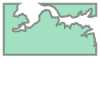

In [9]:
with open('E:\\eo-learn_examples\\theewaterskloof_dam_nominal.wkt','r') as f:
    dam_wkt = f.read()

dam_nominal = shapely.wkt.loads(dam_wkt)
inflate_bbox = 0.1
minx, miny, maxx, maxy = dam_nominal.bounds

delx = maxx - minx
dely = maxy - miny
minx = minx - delx * inflate_bbox
maxx = maxx - delx * inflate_bbox
miny = miny - delx * inflate_bbox
maxy = maxy - delx * inflate_bbox

dam_bbox = BBox([minx,miny,maxx,maxy], crs=CRS.WGS84)

dam_bbox.geometry - dam_nominal

In [6]:
download_task = SentinelHubInputTask(data_collection=DataCollection.SENTINEL2_L1C,
                                     bands_feature=(FeatureType.DATA, 'BANDS'),
                                     resolution=20,
                                     maxcc=0.5,
                                     bands=['B02', 'B03', 'B04', 'B08'],
                                     additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'), (FeatureType.MASK, 'CLM')]
                                    )

calculate_ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDWI'), (1, 3))

In [7]:
dam_gdf = gpd.GeoDataFrame(crs=CRS.WGS84.pyproj_crs(), geometry=[dam_nominal])

C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

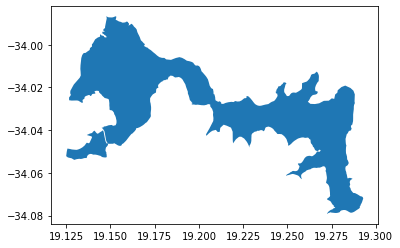

In [8]:
dam_gdf.plot()

In [9]:
add_nominal_water = VectorToRaster(dam_gdf, (FeatureType.MASK_TIMELESS, 'NOMINAL_WATER'), values=1,
                                   raster_shape=(FeatureType.MASK, 'IS_DATA'), raster_dtype=np.uint8)

C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
def calculate_valid_data_mask(eopatch):
    is_data_mask = eopatch.mask['IS_DATA'].astype(np.bool)
    cloud_mask = ~eopatch.mask['CLM'].astype(np.bool)
    return np.logical_and(is_data_mask, cloud_mask)

add_valid_mask = AddValidDataMaskTask(predicate=calculate_valid_data_mask)

C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
def calculate_coverage(array):
    return 1.0 - np.count_nonzero(array) / np.size(array)

class AddValidDataCoverage(EOTask):

    def execute(self, eopatch):

        valid_data = eopatch.get_feature(FeatureType.MASK, 'VALID_DATA')
        time, height, width, channels = valid_data.shape

        coverage = np.apply_along_axis(calculate_coverage, 1,
                                       valid_data.reshape((time, height * width * channels)))

        eopatch.add_feature(FeatureType.SCALAR, 'COVERAGE', coverage[:, np.newaxis])
        return eopatch

add_coverage = AddValidDataCoverage()

C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
cloud_coverage_threshold = 0.05

class ValidDataCoveragePredicate:

    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        return calculate_coverage(array) < self.threshold

remove_cloudy_scenes = SimpleFilterTask((FeatureType.MASK, 'VALID_DATA'),
                                        ValidDataCoveragePredicate(cloud_coverage_threshold))

C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
class WaterDetector(EOTask):

    @staticmethod
    def detect_water(ndwi):
        """
        Very simple water detector based on Otsu thresholding method of NDWI.
        """
        otsu_thr = 1.0
        if len(np.unique(ndwi)) > 1:
            ndwi[np.isnan(ndwi)] = -1
            otsu_thr = threshold_otsu(ndwi)

        return ndwi > otsu_thr

    def execute(self, eopatch):
        water_masks = np.asarray([self.detect_water(ndwi[...,0]) for ndwi in eopatch.data['NDWI']])

        # we're only interested in the water within the dam borders
        water_masks = water_masks[...,np.newaxis] * eopatch.mask_timeless['NOMINAL_WATER']

        water_levels = np.asarray([np.count_nonzero(mask)/np.count_nonzero(eopatch.mask_timeless['NOMINAL_WATER'])
                                   for mask in water_masks])

        eopatch.add_feature(FeatureType.MASK, 'WATER_MASK', water_masks)
        eopatch.add_feature(FeatureType.SCALAR, 'WATER_LEVEL', water_levels[...,np.newaxis])

        return eopatch

water_detection = WaterDetector()

C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
workflow = LinearWorkflow(download_task, calculate_ndwi, add_nominal_water, add_valid_mask,
                          add_coverage, remove_cloudy_scenes, water_detection)

C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
time_interval = ['2017-01-01','2020-06-01']
result = workflow.execute({
    download_task: {
        'bbox': dam_bbox,
        'time_interval': time_interval
    },
})

C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\eolearn\features\bands_extraction.py:86: RuntimeWarning: invalid value encountered in true_divide
  ndi = (band_a - band_b + self.acorvi_constant) / (band_a + band_b + self.acorvi_constant)


In [18]:
patch = list(result.values())[-1]

C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
from skimage.filters import sobel
from skimage.morphology import disk
from skimage.morphology import erosion, dilation, opening, closing, white_tophat

C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
def plot_rgb_w_water(eopatch,idx):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x) / np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    fig, ax = plt.subplots(figsize=(ratio*10,10))
    
    ax.imshow(2.5*eopatch.data['BANDS'][...,[2,1,0]][idx])
    observed = closing(eopatch.mask['WATER_MASK'][idx,...,0], disk(1))
    nominal = sobel(eopatch.mask_timeless['NOMINAL_WATER'][...,0])
    observed = sobel(observed)
    nominal = np.ma.masked_where(nominal == False, nominal)
    observed = np.ma.masked_where(observed == False, observed)
    
    ax.imshow(nominal, cmap=plt.cm.Reds)
    ax.imshow(observed, cmap=plt.cm.Blues)
    ax.axis('off')


C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


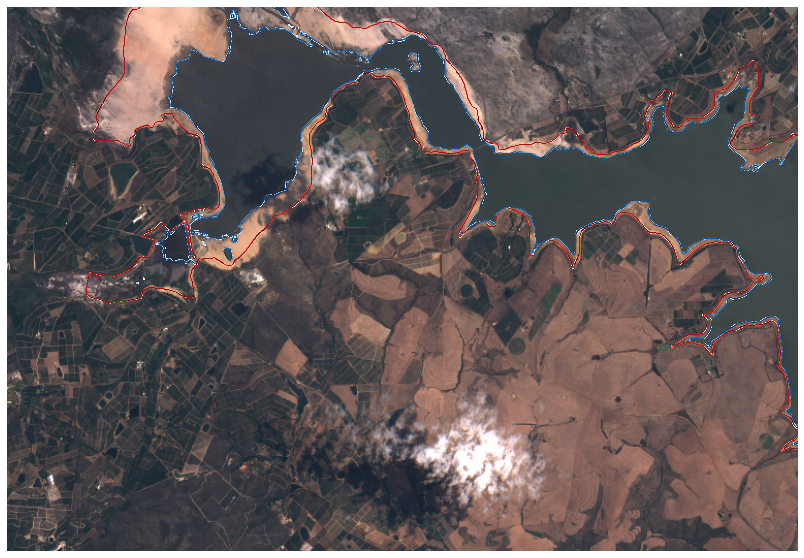

In [82]:
plot_rgb_w_water(patch, 1)

In [ ]:
plt.figure(figsize = (15,30))
plt.subplot(2,2,1)
plt.imshow(np.squeeze(patch.mask_timeless['NOMINAL_WATER']))
plt.subplot(2,2,2)

plt.imshow(patch.mask_timeless['NOMINAL_WATER'])

In [79]:
def plot_water_levels(eopatch, max_coverage=1.0):
    fig,ax = plt.subplots(figsize=(20,7))
    
    dates = np.asarray(eopatch.timestamp)
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0] < max_coverage],
            eopatch.scalar['WATER_LEVEL'][eopatch.scalar['COVERAGE'][...,0] < max_coverage],
           'bo-', alpha=0.7)
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0] < max_coverage],
           eopatch.scalar['COVERAGE'][eopatch.scalar['COVERAGE'][...,0]<max_coverage], '--',color='gray', alpha=0.7)
    ax.set_ylim(0.0, 1.1)
    ax.set_xlabel('Date')
    ax.set_ylabel('Water level')
    ax.set_title('Theewaterskloof Dam Water Levels')
    ax.grid(axis='y')
    return ax

C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


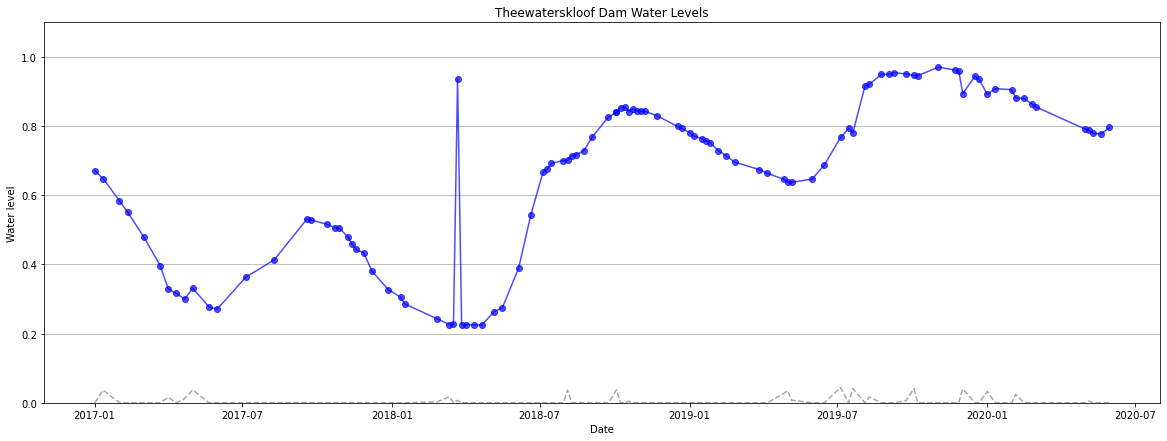

In [83]:
ax = plot_water_levels(patch,1)

In [2]:
sentinelhub.FeatureType

NameError: name 'sentinelhub' is not defined

In [3]:
import sentinelhub as sh

In [4]:
sh.FeatureType

AttributeError: module 'sentinelhub' has no attribute 'FeatureType'

In [11]:
FeatureType.__dir__

C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<function enum.Enum.__dir__(self)>

In [12]:
for i in FeatureType:
    print(i)

FeatureType.DATA
FeatureType.MASK
FeatureType.SCALAR
FeatureType.LABEL
FeatureType.VECTOR
FeatureType.DATA_TIMELESS
FeatureType.MASK_TIMELESS
FeatureType.SCALAR_TIMELESS
FeatureType.LABEL_TIMELESS
FeatureType.VECTOR_TIMELESS
FeatureType.META_INFO
FeatureType.BBOX
FeatureType.TIMESTAMP


C:\Users\afons\.conda\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
